<a href="https://colab.research.google.com/github/shivanijoshi05/speech_emotion_recognition/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [ ]:
from google.colab import drive
import glob
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORT NECESSARY LIBRARIES
import numpy as np
import tensorflow as tf
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
import pandas as pd
from sklearn.metrics import confusion_matrix
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import keras
from keras import layers, models, Model, optimizers
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.python.keras import layers, models, Model, optimizers
from keras import regularizers
from keras import layers, models, Model, optimizers
from random import randint
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib import pyplot
from tensorflow.keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img



Loading Data

In [ ]:
neutral = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/neutral/*.*')
calm = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/calm/*.*')
happy = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/happy/*.*')
sad = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/sad/*.*')
angry = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/angry/*.*')
fearful = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/fearful/*.*')
disgust = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/disgust/*.*')
surprised = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/data_images/surprised/*.*')

In [ ]:
# conversion of data images into matrices
data = []
labels = []

for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')
for i in surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')
data = np.array(data)
labels = np.array(labels)


spliting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=22, test_size=0.2, shuffle=True)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
# conversion of categorical values into numeric form.
lb = LabelEncoder()

# to_categorical(): a numpy array having integers representing categories, can be converted into a numpy array/matrix having binary values.
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1920, 224, 224, 3)
(480, 224, 224, 3)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(1920, 8)
(480, 8)


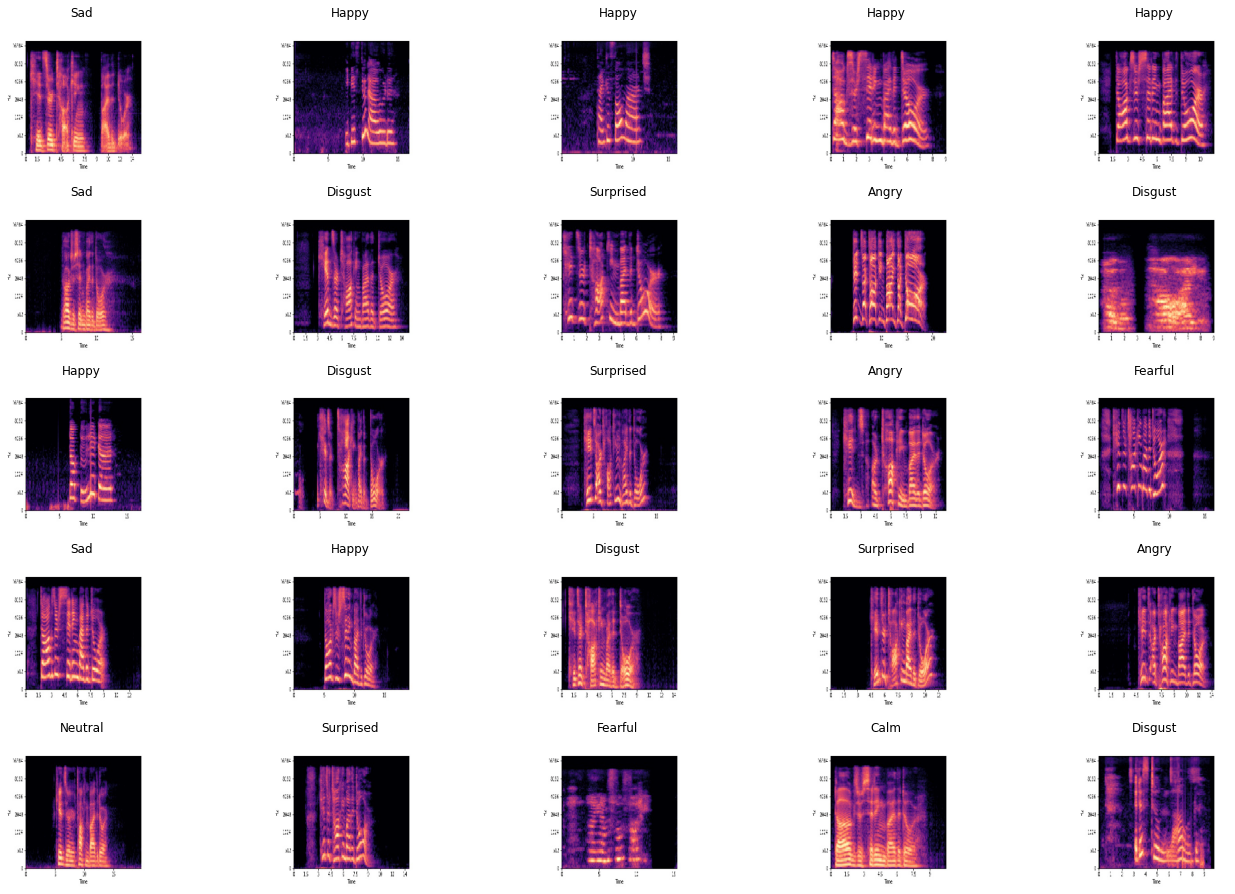

In [ ]:
def get_classlabel(class_code):
    labels = {'Angry':'Angry', 'Calm':'Calm', 'Disgust':'Disgust', 'Fearful':'Fearful', 'Happy':'Happy', 'Neutral':'Neutral','Sad':'Sad','Surprised':'Surprised'}
    
    return labels[class_code]

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(data))
        ax[i,j].imshow(data[rnd_number])
        ax[i,j].set_title(get_classlabel(labels[rnd_number]))
        ax[i,j].axis('off')

# VGG16 Fine Tuning With Image Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16_model = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg16_model.layers[:15]:
    layer.trainable = False

In [ ]:
x = vgg16_model.output
x = Flatten()(x) # Flatten dimensions 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.01)(x)
x = Dense(8, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg16_model.input, outputs=x)

In [ ]:
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# when val_accuracy stops improving,reduce learning rate. 
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.95, 
                              min_lr=0.000001)

checkpoint = ModelCheckpoint('vgg16_augment.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.3,
                                   rotation_range=20,
                                   width_shift_range=0.15)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=1)

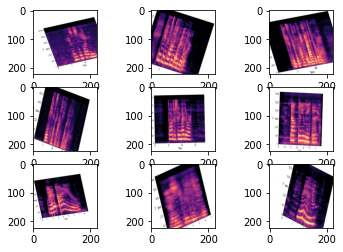

In [ ]:
img_rows, img_cols = 224, 224

for x, y in train_datagen.flow(X_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(x[i].reshape(img_rows, img_cols, 3))
    # show the plot
    pyplot.show()
    break

In [ ]:
from keras import layers, models, Model, optimizers

learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate), metrics=["accuracy"])

history = transfer_model.fit(train_generator,
                    validation_data=(X_test,y_test),
                    epochs=80,
                    callbacks=[lr_reduce,checkpoint])

Epoch 1/80
1920/1920 [==============================] - ETA: 0s - loss: 2.0331 - accuracy: 0.1729
Epoch 1: val_accuracy improved from -inf to 0.24375, saving model to vgg16_augment.h15
INFO:tensorflow:Assets written to: vgg16_augment.h15/assets
1920/1920 [==============================] - 122s 58ms/step - loss: 2.0331 - accuracy: 0.1729 - val_loss: 1.8177 - val_accuracy: 0.2438 - lr: 5.0000e-05
Epoch 2/80
1920/1920 [==============================] - ETA: 0s - loss: 1.7643 - accuracy: 0.2969
Epoch 2: val_accuracy improved from 0.24375 to 0.32083, saving model to vgg16_augment.h15
INFO:tensorflow:Assets written to: vgg16_augment.h15/assets
1920/1920 [==============================] - 103s 54ms/step - loss: 1.7643 - accuracy: 0.2969 - val_loss: 1.6539 - val_accuracy: 0.3208 - lr: 5.0000e-05
Epoch 3/80
1920/1920 [==============================] - ETA: 0s - loss: 1.6119 - accuracy: 0.3901
Epoch 3: val_accuracy improved from 0.32083 to 0.48750, saving model to vgg16_augment.h15
INFO:tensorfl

In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'
transfer_model.save_weights(path +'vgg16_weights2.h5')
transfer_model.save(path + 'vgg16_model2.h5')


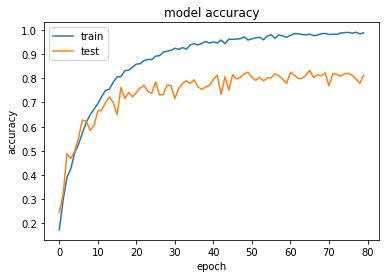

In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + 'vgg16_Model_Accuracy.png')
plt.show()

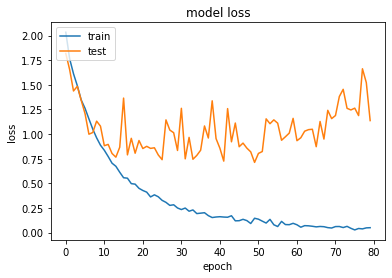

In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + 'vgg16_Model_Loss.png')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

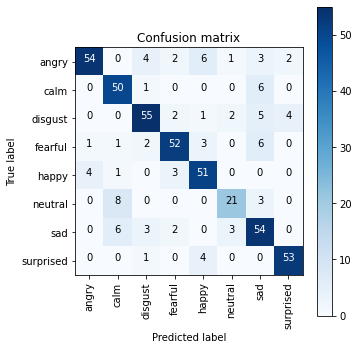

In [ ]:
y_pred = transfer_model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
dict_characters = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names = ['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.92      0.75      0.82        72
        calm       0.76      0.88      0.81        57
     disgust       0.83      0.80      0.81        69
     fearful       0.85      0.80      0.83        65
       happy       0.78      0.86      0.82        59
     neutral       0.78      0.66      0.71        32
         sad       0.70      0.79      0.74        68
   surprised       0.90      0.91      0.91        58

    accuracy                           0.81       480
   macro avg       0.82      0.81      0.81       480
weighted avg       0.82      0.81      0.81       480



# VGG19 Fine Tuning + Augmentation

In [ ]:
from keras.applications import vgg19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19

vgg19_model = vgg19.VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape = (224, 224, 3))

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
#Image Data Augmentation
train_datagen = ImageDataGenerator(
                                    zoom_range=0.5,
                                   rotation_range=20,
                                   width_shift_range=0.5)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=16)

lr_reduce = ReduceLROnPlateau(monitor='val_acc', 
                              patience = 2, 
                              verbose=1,
                              factor=0.95, 
                              min_lr=0.000001)

checkpoint = ModelCheckpoint("vgg19.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)



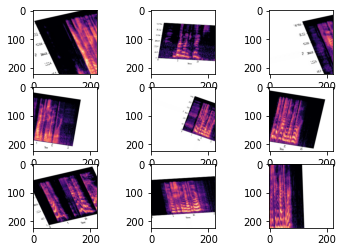

In [ ]:
img_rows, img_cols = 224, 224

for x, y in train_datagen.flow(X_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(x[i].reshape(img_rows, img_cols, 3))
    # show the plot
    pyplot.show()
    break

In [ ]:
for layer in vgg19_model.layers[:12]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(vgg19_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


In [ ]:
input_shape=(224,224,3)

model=models.Sequential()
model.add(vgg19_model)
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(8,activation='softmax'))
model.summary()

#Initializing the hyperparameters
learning_rate = 5e-5
model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate), metrics = ['acc'])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 20,157,768
Trainable params: 17,832,200
Non-trainable params: 2,325,568
_________________________________________________________________


In [ ]:
epochs = 70
history = model.fit(train_generator,
                              epochs = epochs,  
                              validation_data = (X_test,y_test), 
                              callbacks=[checkpoint,lr_reduce], 
                              verbose = 1
                              )

Epoch 1/70
120/120 [==============================] - ETA: 0s - loss: 2.0903 - acc: 0.1307
Epoch 1: val_acc improved from -inf to 0.17292, saving model to vgg19.h5
120/120 [==============================] - 46s 353ms/step - loss: 2.0903 - acc: 0.1307 - val_loss: 1.9911 - val_acc: 0.1729 - lr: 5.0000e-05
Epoch 2/70
120/120 [==============================] - ETA: 0s - loss: 2.0009 - acc: 0.2042
Epoch 2: val_acc improved from 0.17292 to 0.27500, saving model to vgg19.h5
120/120 [==============================] - 42s 349ms/step - loss: 2.0009 - acc: 0.2042 - val_loss: 1.7999 - val_acc: 0.2750 - lr: 5.0000e-05
Epoch 3/70
120/120 [==============================] - ETA: 0s - loss: 1.8619 - acc: 0.2792
Epoch 3: val_acc improved from 0.27500 to 0.33542, saving model to vgg19.h5
120/120 [==============================] - 42s 348ms/step - loss: 1.8619 - acc: 0.2792 - val_loss: 1.6254 - val_acc: 0.3354 - lr: 5.0000e-05
Epoch 4/70
120/120 [==============================] - ETA: 0s - loss: 1.7327 - 

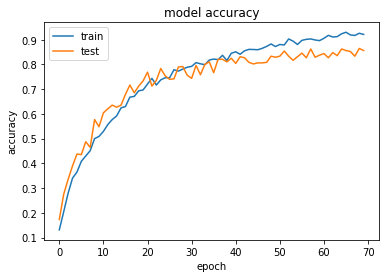

In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(path + 'VGG19_Augmented_Model_Accuracy.png')
plt.show()

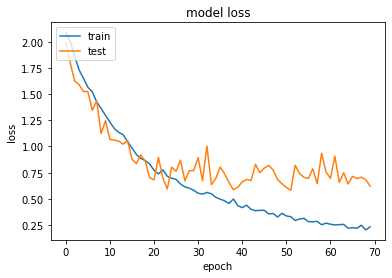

In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + 'VGG19_Augmented_Model_Loss.png')
plt.show()

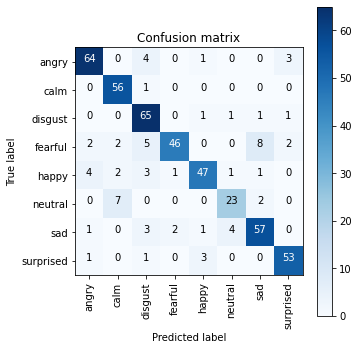

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
dict_characters = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.89      0.89      0.89        72
        calm       0.84      0.98      0.90        57
     disgust       0.79      0.94      0.86        69
     fearful       0.94      0.71      0.81        65
       happy       0.89      0.80      0.84        59
     neutral       0.79      0.72      0.75        32
         sad       0.83      0.84      0.83        68
   surprised       0.90      0.91      0.91        58

    accuracy                           0.86       480
   macro avg       0.86      0.85      0.85       480
weighted avg       0.86      0.86      0.85       480



In [ ]:
path = 'drive/MyDrive/speech_emotion_recognition/models/'
transfer_model.save_weights(path + 'vgg19_weights2.h5')
transfer_model.save(path + 'vgg19_model2.h5')